# Homework 1

Use a Chebyshev method to solve the second order ordinary differential equation

$$ u''(t) + a u'(t) + b u(t) = f(t) $$

from $t=0$ to $t=1$ with initial conditions $u(0) = 1$ and $u'(0) = 0$.

1. Do a grid convergence study to test the accuracy of your method.
* Setting $f(x)=0$, experiment with the values $a$ and $b$ to identify two regimes with qualitatively different dynamics.

In [1]:
%matplotlib inline
import numpy 
from matplotlib import pyplot
pyplot.style.use('ggplot')

a = 1
b = 1
n = 20
t_0 = 0
t_end = 1

In [2]:
def cosspace(a, b, n=50):
    return (a + b)/2 + (b - a)/2 * (numpy.cos(numpy.linspace(-numpy.pi, 0, n)))

In [3]:
class exact_cos:
    def __init__(self, k=1):
        self.k = k

    def u(self, x):
        return numpy.cos(self.k*x)
    def du(self, x):
        return -self.k*numpy.sin(self.k*x)
    def ddu(self, x):
        return -self.k**2*numpy.cos(self.k*x)
ex = exact_cos(k=5)

Chebyshev polinomial defined as
$$\begin{split}
T_0(x) &= 1 \\
T_1(x) &= x \\
T_{n}(x) &= 2 x T_{n-1}(x) - T_{n-2}(x)
\end{split}$$

In [4]:
def vander_chebyshev(x, n=None):
    """Build matrices to evaluate the n-term Chebyshev expansion at point(s) x"""
    if n is None:
        n = len(x)
    T = numpy.ones((len(x), n))
    if n > 1:
        T[:,1] = x
    for k in range(2,n):
        T[:,k] = 2 * x * T[:,k-1] - T[:,k-2]
    return T

We can differentiate Chebyshev polynomials using the recurrence

$$ \frac{T_n'(x)}{n} = 2 T_{n-1}(x) + \frac{T_{n-2}'(x)}{n-2} $$

which we can differentiate to evaluate higher derivatives.

In [5]:
def chebeval(z, n=None):
    """Build matrices to evaluate the n-term Chebyshev expansion and its derivatives at point(s) z"""
    z = numpy.array(z, ndmin=1)
    if n is None:
        n = len(z)
    Tz = vander_chebyshev(z, n)
    dTz = numpy.zeros_like(Tz)
    dTz[:,1] = 1
    dTz[:,2] = 4*z
    ddTz = numpy.zeros_like(Tz)
    ddTz[:,2] = 4
    for n in range(3,n):
        dTz[:,n]  = n * (2*Tz[:,n-1] + dTz[:,n-2]/(n-2))
        ddTz[:,n] = n * (2*dTz[:,n-1] + ddTz[:,n-2]/(n-2))
    return [Tz, dTz, ddTz]

Now we can rewrite our problem in discrete form:
$$(L_2+aL_1+bI)U = F,$$
where $I$ is identity matrix,
$$L_2=T''T^{-1},$$
$$L_1=T'T^{-1}.$$

In [6]:
def discretize(n, a, b, rhsfunc):
    t = cosspace(t_0, t_end, n)
    rhs = rhsfunc(t)

    T = chebeval(t)
    L2 = T[2].dot(numpy.linalg.inv(T[0]))
    L1 = T[1].dot(numpy.linalg.inv(T[0]))
    A = L2+a*L1+b*numpy.diag(numpy.ones(n))
    print('n = {}, cond(A) = {}'.format(n, numpy.linalg.cond(A)))
    
    # Boundary conditions
    A[:2,:] = 0 
    A[0,0] = 1
    rhs[0] = 1

    A[1,0] = -1
    A[1,1] = 1
    rhs[1] = 0                        
                             
    return t, A, rhs

## 1. Do a grid convergence study to test the accuracy of your method.

In [7]:
t, A, rhs = discretize(n, a, b, lambda x:ex.ddu(x) + a*ex.du(x) + b*ex.u(x))
u = numpy.linalg.solve(A, rhs)

n = 20, cond(A) = 42826077.20719322


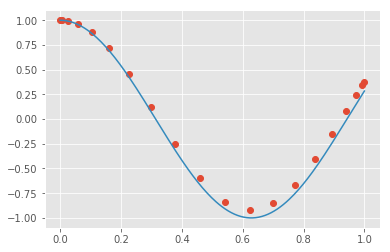

In [8]:
tt = numpy.linspace(t_0, t_end, 200)
# x, L, rhs = laplacian_cheb(20, lambda x: ex.ddu(x)+a*ex.du(x)+b*ex.u(x), left1=(0,ex.u), left2=(1,ex.du))
pyplot.plot(t, u, 'o')
pyplot.plot(tt, ex.u(tt));

n = 10, cond(A) = 49540839898192.62
n = 12, cond(A) = 6794172889034.239
n = 14, cond(A) = 2251091113692.515
n = 16, cond(A) = 18177528329.92726
n = 18, cond(A) = 641765362.0646642
n = 20, cond(A) = 42826077.20719322
n = 22, cond(A) = 1488049.68963962
n = 24, cond(A) = 127412.02376315347
n = 26, cond(A) = 208889.2227771958
n = 28, cond(A) = 62347.451905461174
n = 30, cond(A) = 43202.05863785191
n = 32, cond(A) = 95889.00492095547
n = 34, cond(A) = 613181.0064571481
n = 36, cond(A) = 74453.46031689527
n = 38, cond(A) = 3943313.295397768


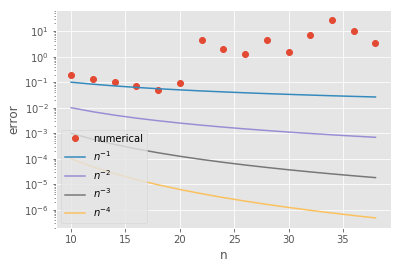

In [9]:
def mms_error(n, discretize, sol):
    x, L, f = discretize(n, a, b,  lambda x: sol.ddu(x) + a*sol.du(x) + b*sol.u(x))
    u = numpy.linalg.solve(L, f)
    return numpy.linalg.norm(u - sol.u(x), numpy.inf)

ns = numpy.arange(10,40,2)
errors = [mms_error(n, discretize, ex) for n in ns]
pyplot.figure()
pyplot.semilogy(ns, errors, 'o', label='numerical')
for p in range(1,5):
    pyplot.semilogy(ns, 1/ns**(p), label='$n^{-%d}$'%p)
pyplot.xlabel('n')
pyplot.ylabel('error')
    
pyplot.legend(loc='lower left');

The problem is that we defined Chebyshev polynomial on $[0,1]$, while they are stable on $[-1,1]$.

Shifted Chebyshev polynomials of the first kind are defined as
$$T_{n}^{*}(t)=T_{n}(2t-1),$$
where $t \in [0,1]$ and $x = 2t-1 \in [-1,1]$.

Then for derivatives
$$T' = \frac{dT(x)}{dt} = \frac{dT(x)}{dx}\frac{dx}{dt} = 2\frac{dT(x)}{dx},$$
$$T'' = \frac{d^2T(x)}{dt^2} = \frac{d}{dt}\left( \frac{dT(x)}{dt} \right) = \frac{d}{dt}\left(\frac{dT(x)}{dx}\frac{dx}{dt} \right) = \frac{d^2T(x)}{dx^2}\left(\frac{dx}{dt}\right)^2 + \frac{dT(x)}{dx}\frac{d^2x}{dt^2} =  4\frac{d^2T(x)}{dx^2}$$

In [10]:
def chebeval_improved(t, dx = 2, n=None):
    """Build matrices to evaluate the n-term Chebyshev expansion and its derivatives at point(s) z"""
    x = cosspace(-1, 1, len(t))
    if n is None:
        n = len(t)
    Tx = vander_chebyshev(x, n)
    dTx = numpy.zeros_like(Tx)
    dTx[:,1] = 1
    dTx[:,2] = 4*x
    ddTx = numpy.zeros_like(Tx)
    ddTx[:,2] = 4
    for n in range(3,n):
        dTx[:,n]  = n * (2*Tx[:,n-1] + dTx[:,n-2]/(n-2))
        ddTx[:,n] = n * (2*dTx[:,n-1] + ddTx[:,n-2]/(n-2))

    return [Tx, dx*dTx, dx**2*ddTx]

In [11]:
def discretize_improved(n, a, b, rhsfunc): 
    t = cosspace(t_0, t_end, n)
    x = cosspace(-1, 1, len(t))
    dx = 2/(t_end-t_0)
    
    rhs = rhsfunc(t)

    T = chebeval_improved(t, dx)
    L2 = T[2].dot(numpy.linalg.inv(T[0]))
    L1 = T[1].dot(numpy.linalg.inv(T[0]))
    A = L2+a*L1+b*numpy.diag(numpy.ones(n))
    
    # Boundary conditions
    A[:2,:] = 0 
    A[0,0] = 1
    rhs[0] = 1

    A[1,0] = -1
    A[1,1] = 1
    rhs[1] = 0                        
                             
    return t, A, rhs

n = 150, cond(A) = 12445432650997.248


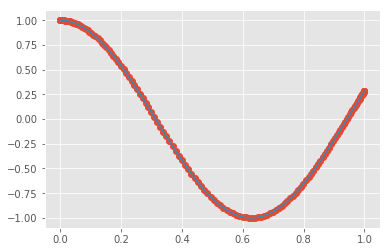

In [12]:
n = 150
t, A, rhs = discretize_improved(n, a, b, lambda t:ex.ddu(t) + a*ex.du(t) + b*ex.u(t))
u = numpy.linalg.solve(A, rhs)
print('n = {}, cond(A) = {}'.format(n, numpy.linalg.cond(A)))

tt = numpy.linspace(t_0, t_end, 200)
pyplot.plot(t, u, 'o')
pyplot.plot(tt, ex.u(tt));

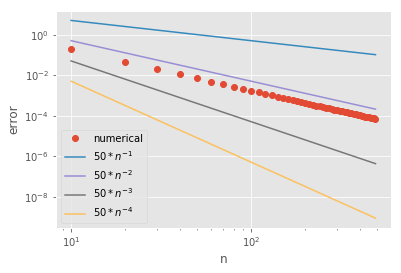

In [13]:
ns = numpy.arange(10,500,10)
errors = [mms_error(n, discretize_improved, ex) for n in ns]
pyplot.figure()
pyplot.semilogy(ns, errors, 'o', label='numerical')
for p in range(1,5):
    pyplot.loglog(ns, 50*1/ns**(p), label='$50*n^{-%d}$'%p)
pyplot.xlabel('n')
pyplot.ylabel('error')
    
pyplot.legend(loc='lower left');

From this plot we can see, that accuracy of the method is about second order.

# 2.Setting $f(x)=0$, experiment with the values $a$ and $b$ to identify two regimes with qualitatively different dynamics.

In [14]:
n = 150

n = 150, cond(A) = 559707606650.7428


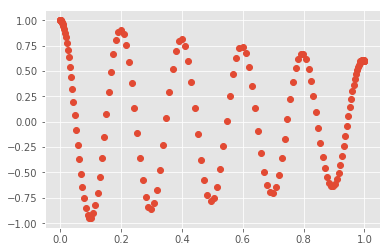

In [15]:
a = 1
b = 1000
t, A, rhs = discretize_improved(n, a, b, lambda x: 0*x)
u = numpy.linalg.solve(A, rhs)
print('n = {}, cond(A) = {}'.format(n, numpy.linalg.cond(A)))
tt = numpy.linspace(t_0, t_end, 200)
pyplot.plot(t, u, 'o');

n = 150, cond(A) = 462321169538.97284


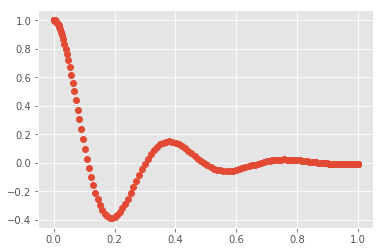

In [16]:
a = 10
b = 300
t, A, rhs = discretize_improved(n, a, b, lambda x: 0*x)
u = numpy.linalg.solve(A, rhs)
print('n = {}, cond(A) = {}'.format(n, numpy.linalg.cond(A)))
tt = numpy.linspace(t_0, t_end, 200)
pyplot.plot(t, u, 'o');

n = 150, cond(A) = 79888484371094.08


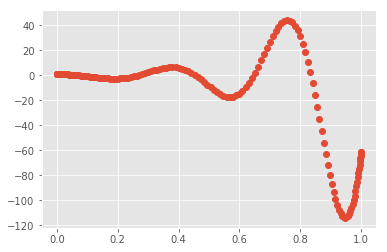

In [17]:
a = -10
b = 300
t, A, rhs = discretize_improved(n, a, b, lambda x: 0*x)
u = numpy.linalg.solve(A, rhs)
print('n = {}, cond(A) = {}'.format(n, numpy.linalg.cond(A)))
tt = numpy.linspace(t_0, t_end, 200)
pyplot.plot(t, u, 'o');

We can see from this results, that coefficient $b$ is responsible for frequancy of the function and coefficient $s$ is responsible for decay (positive values) or growth (negative values) of amplitude.